Author: Akshay Chougule

Creation Date: 14-Feb-2020

Description: This is a v6 of notebook for Human-Protein-Atlas-Competition.

Change log: Try SMOTE

In [1]:
import pandas as pd
import wget
import time
import os
import copy

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *
from fastai.vision import *

In [4]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [151]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [152]:
train_labels.shape

(31072, 2)

In [153]:
# Over sampling from: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74374
train_labels_orig=train_labels.copy()    
#lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]
lows = [8,9,20,17,16,13,8,9,20,24,26,20,8,9,17,24,26,20,8,9,17,24,8,9,20,26,16,13,8,9,20,17,24,26]
for i in lows:
    target = str(i)
    indicies = train_labels_orig.loc[train_labels_orig['Target'] == target].index
    train_labels = pd.concat([train_labels,train_labels_orig.loc[indicies]], ignore_index=True)
    indicies = train_labels_orig.loc[train_labels_orig['Target'].str.startswith(target+" ")].index
    train_labels = pd.concat([train_labels,train_labels_orig.loc[indicies]], ignore_index=True)
    indicies = train_labels_orig.loc[train_labels_orig['Target'].str.endswith(" "+target)].index
    train_labels = pd.concat([train_labels,train_labels_orig.loc[indicies]], ignore_index=True)
    indicies = train_labels_orig.loc[train_labels_orig['Target'].str.contains(" "+target+" ")].index
    train_labels = pd.concat([train_labels,train_labels_orig.loc[indicies]], ignore_index=True)

In [154]:
train_labels.shape

(38266, 2)

In [155]:
train_labels.iloc[38200:38266,:]

,Id,Target
38200,bbb5c09a-bbc4-11e8-b2bc-ac1f6b6435d0,26 3
38201,bc64e57e-bbb1-11e8-b2ba-ac1f6b6435d0,26 3 0 21
38202,be8d21fa-bbb5-11e8-b2ba-ac1f6b6435d0,26 25
38203,c0061cfe-bba5-11e8-b2ba-ac1f6b6435d0,26 0
38204,c00e083c-bbbf-11e8-b2bb-ac1f6b6435d0,26 0
38205,c076a186-bbaf-11e8-b2ba-ac1f6b6435d0,26 0
38206,c0c3760c-bbad-11e8-b2ba-ac1f6b6435d0,26 0
38207,c18e9e28-bbac-11e8-b2ba-ac1f6b6435d0,26 2 0
38208,c2b2b700-bb9b-11e8-b2b9-ac1f6b6435d0,26 0
38209,c4658eda-bba3-11e8-b2b9-ac1f6b6435d0,26 25


In [156]:
train_labels.to_csv(os.path.join(data_root,"train_labels_oversampled_v2.csv"), index=False)

__Create the databunch__

In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [158]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [159]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512',suffix='.png')

In [9]:
class BalancedSampler(Sampler):

    def __init__(self, X, y, sampler=None, random_state=None):
        self.X = X
        self.y = y
        self.sampler = sampler
        self.random_state = random_state
        self._sample()

    def _sample(self):
        random_state = check_random_state(self.random_state)
        if self.sampler is None:
            self.sampler_ = RandomUnderSampler(return_indices=True,
                                               random_state=random_state)
        else:
            if not hasattr(self.sampler, 'return_indices'):
                raise ValueError("'sampler' needs to return the indices of "
                                 "the samples selected. Provide a sampler "
                                 "which has an attribute 'return_indices'.")
            self.sampler_ = clone(self.sampler)
            self.sampler_.set_params(return_indices=True)
            set_random_state(self.sampler_, random_state)

        _, _, self.indices_ = self.sampler_.fit_sample(self.X, self.y)
        # shuffle the indices since the sampler are packing them by class
        random_state.shuffle(self.indices_)

    def __iter__(self):
        return iter(self.indices_.tolist())

    def __len__(self):
        return len(self.X.shape[0])

It seems oversampling of minority class followed by undersamping of majority class work better than standalone techniques.

In [15]:
#!pip install -U imbalanced-learn

In [16]:
# WE wanna try the following
# SMOTE + Tomek links 
# SMOTE + ENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

In [17]:
# Useful resource
# https://github.com/koushik-elite/Using-Densenet-and-PyTorch/blob/cc7c162c33f72ebc97f32d7829b1a3833b6de564/Using%20Densenet%20and%20PyTorch.ipynb

In [18]:
# Useful Resource // DEals with imbalanced class by using weights but in pytorch
# https://www.kaggle.com/tanlikesmath/oversampling-mnist-with-fastai

In [163]:
src = (ImageList.from_csv(data_root,'train_labels_oversampled_v2.csv',folder='train_512by512',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [164]:
src.train.databunch

<bound method LabelList.databunch of LabelList (30613 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: /home/ubuntu/datasets/human-protein-atlas>

In [165]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (7653 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
12,13;21,12,19;11;0,5
Path: /home/ubuntu/datasets/human-protein-atlas>

In [166]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

In [167]:
data = (src.transform(tfms, size=512)
        .databunch(bs = 8).normalize(imagenet_stats))

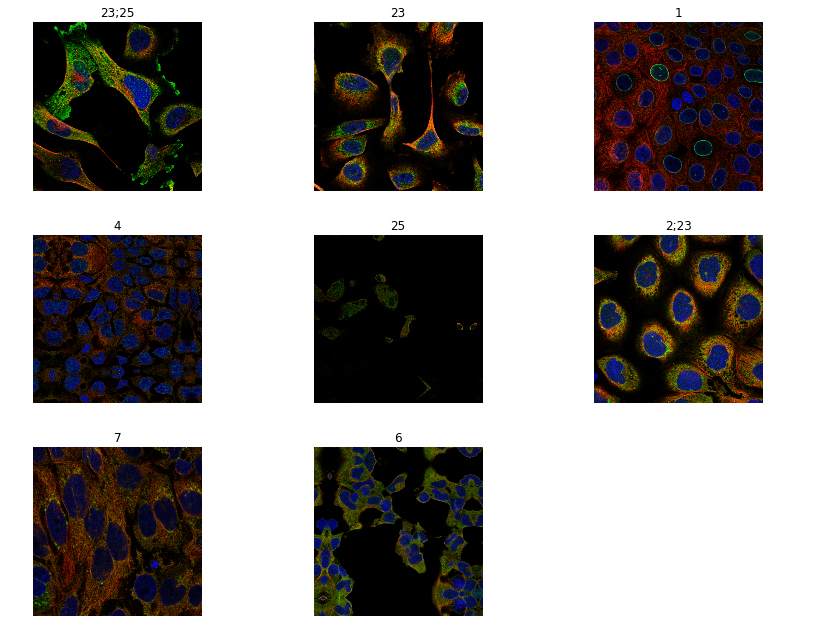

In [168]:
data.show_batch(rows=3, figsize=(12,9))

In [169]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

In [170]:
# Focal loss : https://colab.research.google.com/drive/1NiUwI6ohF1b9TthutyfJQnOJ2i39R5cJ#scrollTo=qo8kiV3mtC-S

def focal_loss(y_pred,y_true,alpha=0.25,gamma=0):
    
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 28 class
     #y_true = torch.eye(y_pred.shape[-1])[y_true].cuda() # one hot vector for all prediction
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    y_true = y_true.to('cuda')
        
    # in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor      
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
        
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    focal_weight = focal_weight.to('cuda')
    cross_entropy = cross_entropy.to('cuda')
    alpha_factor = alpha_factor.to('cuda')
    
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

In [171]:
arch = models.resnet18
F1 = MultiLabelFbeta(beta=2, average="macro")

__PART 1: Oversampling callback with weights__

It seems SMOTE with multi-label is not available in imbalanced-learn. So we will just try other methods of oversampling.

In [48]:
# from itertools import chain
# def flatten(listOfLists):
#     "Flatten one level of nesting"
#     return chain.from_iterable(listOfLists)

In [54]:
# flatten = lambda l: [item for sublist in l for item in sublist]

In [71]:
# Over sampling callback with weights

# from torch.utils.data.sampler import WeightedRandomSampler

# class OverSamplingCallback(LearnerCallback):
#     def __init__(self,learn:Learner):
#         super().__init__(learn)
#         self.labels = np.array(flatten(self.learn.data.train_dl.dataset.y.items))
#         #np.reshape(self.labels, self.labels.size)
#         print(self.labels.shape)
#         _, counts = np.unique(self.labels,return_counts=True)
#         self.weights = torch.DoubleTensor((1/counts)[self.labels])
#         self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
#         self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
        
#     def on_train_begin(self, **kwargs):
#         self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)

In [78]:
# len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(24858, 6214, 11702)

In [172]:
setattr(src, 'device', 'cuda') 

In [180]:
learn = cnn_learner(data, arch, metrics=F1)

In [181]:
learn.loss_func=focal_loss

In [182]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


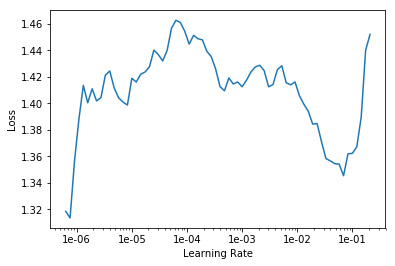

In [183]:
learn.recorder.plot()

In [184]:
# 0.01 gives nan
lr = 0.001

In [185]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.738609,0.710333,0.267992,03:41
1,0.714133,0.661265,0.366310,03:43
2,0.678962,0.631702,0.407812,03:39
3,0.647953,0.617352,0.419846,03:40
4,0.659915,0.614748,0.412200,03:42


In [34]:
# from previous version of notebook (without over-sampling)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.727996,0.683244,0.229337,02:58
1,0.673478,0.643224,0.274675,03:01
2,0.658434,0.616653,0.309232,03:00
3,0.640163,0.608615,0.322376,02:58
4,0.618690,0.600328,0.318781,02:58


In [186]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


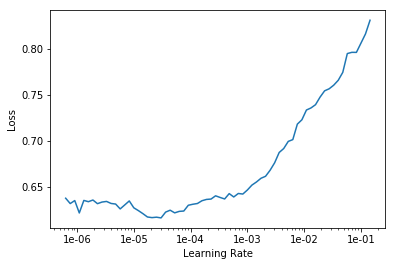

In [187]:
learn.lr_find()
learn.recorder.plot()

In [188]:
learn.fit_one_cycle(20, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.649619,0.605245,0.424601,04:57
1,0.628787,0.590176,0.445471,04:58
2,0.605097,0.566811,0.491412,04:59
3,0.596415,0.556241,0.516654,04:58
4,0.566042,0.534384,0.531545,04:57
5,0.561799,0.529356,0.543139,04:57
6,0.543892,0.501772,0.563350,04:57
7,0.537213,0.498939,0.554262,04:57
8,0.502381,0.483884,0.554675,04:57
9,0.507768,0.476005,0.549156,04:58


In [37]:
# from previous version of notebook (without over-sampling)
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.617417,0.591561,0.326415,04:00
1,0.598871,0.573756,0.346218,04:01
2,0.575802,0.562892,0.360130,04:02
3,0.564818,0.550387,0.382513,04:00
4,0.556065,0.526123,0.430614,04:00
5,0.553219,0.517914,0.442144,04:01
6,0.544462,0.524534,0.438760,04:01
7,0.519567,0.507769,0.465292,04:01
8,0.517843,0.492788,0.472422,04:02
9,0.502170,0.487753,0.483362,04:02


### Testing

__Making the predictions__

In [189]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [190]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

Let's try playing around with the threshold

In [191]:
thresholds = [0.18,0.16,0.14,0.12,0.10]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V6_stag3_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [192]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V6_stag3_thresh_0.18.csv -m "Model v6 with resnet18 stage-3 and thrsd 0.18"

100%|█████████████████████████████████████████| 443k/443k [00:00<00:00, 613kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [193]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V6_stag3_thresh_0.16.csv -m "Model v6 with resnet18 stage-3 and thrsd 0.16"

100%|█████████████████████████████████████████| 444k/444k [00:00<00:00, 801kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [194]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V6_stag3_thresh_0.14.csv -m "Model v6 with resnet18 stage-3 and thrsd  0.14"

100%|█████████████████████████████████████████| 444k/444k [00:00<00:00, 624kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [195]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V6_stag3_thresh_0.12.csv -m "Model v6 with resnet18 stage-3 and thrsd 0.12"

100%|█████████████████████████████████████████| 444k/444k [00:00<00:00, 750kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [196]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V6_stag3_thresh_0.1.csv -m "Model v6 with resnet18 stage-3 and thrsd  0.1"

100%|█████████████████████████████████████████| 445k/445k [00:00<00:00, 534kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [198]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!head results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V6_stag3_thresh_0.18.csv     2020-02-15 02:32:58  Model v6 with resnet18 stage-3 and thrsd 0.18     pending   None         None          
protein_classification_nb-V6_stag3_thresh_0.1.csv      2020-02-15 00:01:24  Model v6 with resnet18 stage-3 and thrsd  0.1     complete  0.28833      0.27330       
protein_classification_nb-V6_stag3_thresh_0.12.csv     2020-02-15 00:01:20  Model v6 with resnet18 stage-3 and thrsd 0.12     complete  0.28650      0.26772       
protein_classification_nb-V6_stag3_thresh_0.14.csv     2020-02-15 00:01:17  Model v6 with resnet18 stage-3 and thrsd  0.14    complete  0.28521      0.26526       
protein_classifi